In [1]:
# https://gist.github.com/endolith/255291
# https://stackoverflow.com/questions/49531952/find-period-of-a-signal-out-of-the-fft

In [1]:
import numpy as np
from scipy.signal import correlate
import parabolic
import matplotlib.pyplot as plt

C:\Users\Kaushik\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Kaushik\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\Kaushik\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
ts_0 = [2.762, 2.762, 1.508, 2.758, 2.765, 2.765, 2.761, 1.507, 2.757, 2.757, 2.764, 2.764, 1.512, 2.76, 2.766, 2.766, 2.763, 1.51, 2.759, 2.759, 2.765, 2.765, 1.514, 2.761, 2.758, 2.758, 2.764, 1.513, 2.76, 2.76, 2.757, 2.757, 1.508, 2.763, 2.759, 2.759, 2.766, 1.517]

ts_1 = [2.762, 2.762, 1.508, 2.758, 2.765, 2.765, 2.761, 1.507, 2.757, 2.757, 2.764, 2.764, 1.512, 2.76, 2.766, 2.766, 2.763, 1.51, 2.759, 2.759, 2.765, 2.765, 1.514, 2.761, 2.758, 2.758, 2.764, 1.513, 2.76, 2.76, 2.757, 2.757, 1.508, 2.763, 2.759, 2.759, 2.766, 1.517, 4.012]

ts_2 = [2.762, 2.762, 1.508, 1.508, 1.608, 2.758, 2.765, 2.765, 2.761, 1.507, 1.517, 2.757, 2.757, 2.764, 1.512, 2.76, 2.766, 2.766, 2.763, 1.51, 1.508, 1.608, 2.759, 2.759, 2.765, 2.765, 1.514, 1.524, 1.514, 2.761, 2.758, 2.758, 2.764, 1.513, 1.514, 1.514, 2.76, 2.76, 1.508, 1.511, 1.522, 2.763, 2.759, 2.759, 2.766, 1.517]

ts_3 = [2.762, 2.762, 1.508, 1.508, 1.608, 2.758, 4.765, 2.065, 2.761, 1.507, 1.517, 2.757, 4.757, 2.964, 1.512, 2.76, 2.766, 2.766, 2.763, 1.51, 1.508, 1.608, 2.759, 4.759, 2.065, 2.765, 1.514, 1.524, 1.514, 2.761, 5.758, 2.158, 2.764, 1.513, 1.514, 1.514, 2.76, 2.76, 1.508, 1.511, 1.522, 2.763, 4.759, 2.759, 2.766, 1.517]

ts_4 = [2.762, 2.762, 1.508, 1.508, 1.608, 2.758, 2.765]

ts_5 = [0,0,0,50,0,0,0,100,0,0,0,50,0,0,0,100,0,0,0,50,0,0,0,100,0,0,0,50,0,0,0,100,0,0,0,50,0,0,0,100]

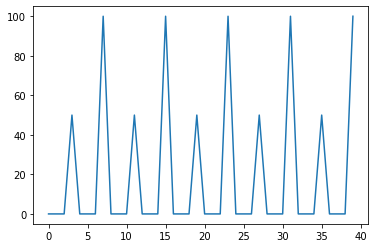

In [3]:
ts = ts_5
plt.plot(ts);

In [7]:
high_thr = np.quantile(ts, 0.90)
print(high_thr)

100.0


In [5]:
def parabolic_interpolation(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
    f is a vector and x is an index for that vector.
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
    In [4]: parabolic_interpolation(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def find_periodicity_from_crossings(sig, high_thr, low_thr, fs=1): 
    """
    Estimate frequency by counting crossings of high threshold
    """
    sig = np.array(sig)
    
    # Find all indices right before a rising-edge  
    indices = np.nonzero((sig[1:] >= high_thr) & (sig[:-1] < high_thr))[0]

    # Intersample crossings
    crossings = indices

    # Find periodicity
    return np.mean(np.diff(crossings)) / fs

def find_periodicity_from_autocorr(sig, fs=1):
    """
    Estimate frequency using autocorrelation
    """
    # Calculate autocorrelation and throw away the negative lags
    corr = correlate(sig, sig, mode='full')
    corr = corr[len(corr)//2:]

    # Find the first low point
    d = np.diff(corr)
    if len(np.nonzero(d > 0)[0]) > 0:
        start = np.nonzero(d > 0)[0][0]
    else:
        start = np.argmax(d)

    # Find the next peak after the low point (other than 0 lag).  This bit is
    # not reliable for long signals, due to the desired peak occurring between
    # samples, and other peaks appearing higher.
    # Should use a weighting function to de-emphasize the peaks at longer lags.
    peak = np.argmax(corr[start:]) + start
    peak = min(len(corr)-2, peak)
    px, py = parabolic_interpolation(corr, peak)
    
    # Find periodicity
    return px / fs

def find_periodicity(sig, high_thr, fs=1):
    T_crossings = find_periodicity_from_crossings(sig, high_thr, fs)
    T_autocorr = find_periodicity_from_autocorr(sig, fs)
    if np.isnan(T_crossings):
        periodicity = T_autocorr
    else:
        periodicity = np.mean([T_crossings, T_autocorr])
    
    return np.round(periodicity)

In [8]:
find_periodicity(ts, high_thr)

8.0

In [9]:
find_periodicity_from_autocorr(ts, 1)

8.0